<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Galaxy Creation Station</h1>
    <p style="text-align:center;">This notebook demonstrates the method in Wagg et al. (2021) for sampling positions and metallicities in the Milky Way and how to reproduce Figure 1.</p>
</div>

In [313]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.integrate import quad
from scipy.stats import beta

# custom LISA package
import legwork

# import code from repo
import sys
sys.path.append("../../simulation/src/")
import galaxy

from importlib import reload

In [2]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 24

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [139]:
# masses
stellar_mass = {
    "bulge": 0.91e10 * u.Msun,
    "thin": 5.17e10 * u.Msun / 2,
    "thick": 5.17e10 * u.Msun / 2,
}

total_stellar_mass = 6.08e10 * u.Msun

stellar_mass_fractions = {}
for key in stellar_mass.keys():
    stellar_mass_fractions[key] = stellar_mass[key] / total_stellar_mass

# Thin Disc
For the Milky Way thin disc, we use the model from Frankel et al. 2018 (hereafter F18). The authors developed this model in order to measure the global efficiency of radial migration in the Milky Way. They did this by fitting the model to a sample of red clump stars measured with APOGEE and Gaia. The result of this work is a model for the Milky Way that is calibrated to observations and which includes the star formation history, radial birth profile and chemical enrichment history of the galaxy. We can therefore use this model to place binaries randomly in space and time and match these positions to a metallicity.

## Star formation history
First, we can take a look at the star formation history which exponentially declines over the age of the Milky Way.

In [237]:
def thin_disc_SFH(t, tm=12*u.Gyr, tsfr=6.8*u.Gyr):
    norm = quad(lambda t: np.exp(-(tm - t * u.Gyr) / tsfr), 0, 8)[0]
    SFH = np.exp(-(tm - t) / tsfr) / norm
    SFH[np.logical_or(t < 0 * u.Gyr, t >= 8 * u.Gyr)] = 0.0
    return SFH

def thick_disc_SFH(t, tm=12*u.Gyr, tsfr=6.8*u.Gyr):
    norm = quad(lambda t: np.exp(-(tm - t * u.Gyr) / tsfr), 8, tm.to(u.Gyr).value)[0]
    SFH = np.exp(-(tm - t) / tsfr) / norm
    SFH[np.logical_or(t < 8 * u.Gyr, t > tm)] = 0.0
    return SFH

def bulge_SFH(t):
    return beta(2, 3, loc=6, scale=6).pdf(t.to(u.Gyr).value)

def total_SFH(t):
    return stellar_mass_fractions["bulge"] * bulge_SFH(t) \
        + stellar_mass_fractions["thin"] * thin_disc_SFH(t) \
        + stellar_mass_fractions["thick"] * thick_disc_SFH(t)

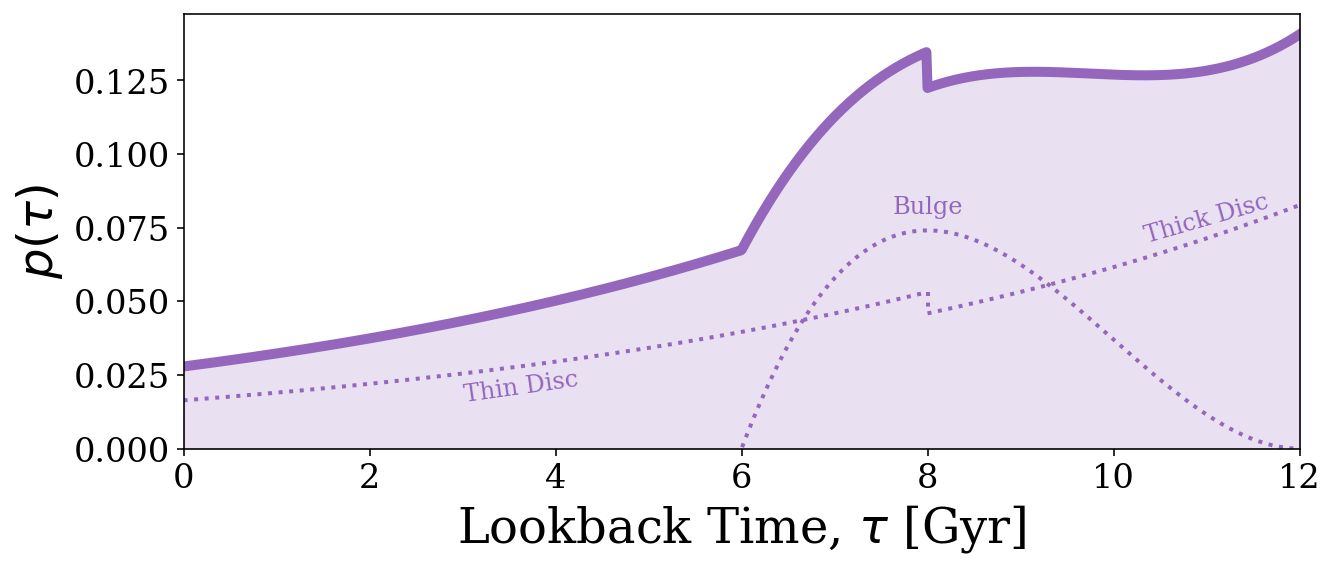

In [346]:
fig, ax = plt.subplots(1, figsize=(10, 4))

t_range = np.linspace(0, 12, 1000) * u.Gyr

nonzero = thin_disc_SFH(t_range) > 0.0
ax.plot(t_range[nonzero], thin_disc_SFH(t_range)[nonzero] * 0.25, color="tab:purple", lw=2, linestyle="dotted")

nonzero = thick_disc_SFH(t_range) > 0.0
ax.plot(t_range[nonzero], thick_disc_SFH(t_range)[nonzero] * 0.25, color="tab:purple", lw=2, linestyle="dotted")

nonzero = bulge_SFH(t_range) > 0.0
ax.plot(t_range[nonzero], bulge_SFH(t_range)[nonzero] * 0.25, color="tab:purple", lw=2, linestyle="dotted")

ax.plot([8, 8] * u.Gyr, np.array([thin_disc_SFH(7.999 * u.Gyr), thick_disc_SFH(8 * u.Gyr)]) * 0.25, lw=2, linestyle="dotted", color="tab:purple")

ax.plot(t_range, total_SFH(t_range), color="tab:purple", lw=5)
ax.fill_between(t_range, 0, total_SFH(t_range), color="tab:purple", alpha=0.2)

ax.set_xlabel(r"Lookback Time, $\tau$ [Gyr]")
ax.set_ylabel(r"$p(\tau)$")

ax.set_xlim(0, 12)
ax.set_ylim(bottom=0)

ax.annotate("Thin Disc", xy=(3, 0.016), rotation=8, fontsize=0.5*fs, color="tab:purple")
ax.annotate("Bulge", xy=(8, 0.08), ha="center", fontsize=0.5*fs, color="tab:purple")
ax.annotate("Thick Disc", xy=(11, 0.07), ha="center", rotation=16, fontsize=0.5*fs, color="tab:purple")

plt.show()

## Radial distribution
For the radial distribution we use the birth radius distribution from F18. The distribution changes over the age of the Milky Way and gradually becomes more spread out.

In [167]:
def Rexp(t, alpha=0.3):
    return 4 * u.kpc * (1 - alpha * (t / (8 * u.Gyr)))

def P_R0(R0, t): 
    return np.exp(-R0 / Rexp(t)) / Rexp(t) * (R0 / Rexp(t))

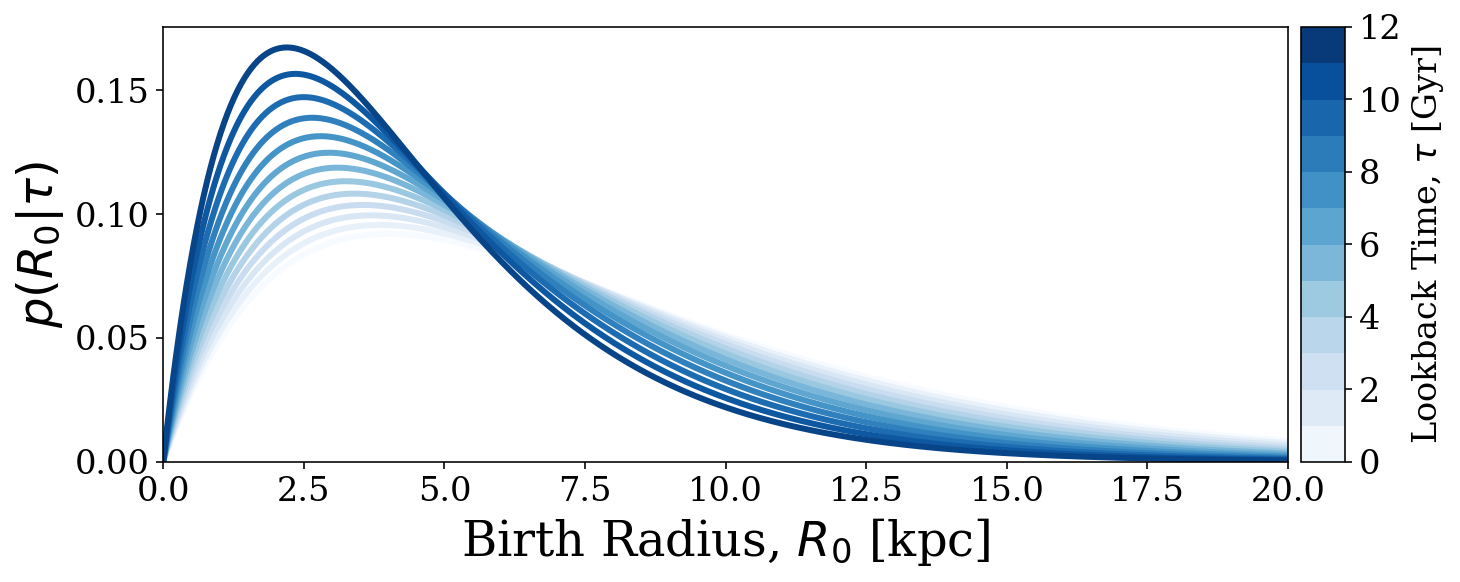

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 4))

cmap = "Blues"

R_range = np.linspace(0, 20, 1000) * u.kpc
t_range = np.linspace(0, 12, 13)

# plot a separate distribution for lots of lookback times
for t in t_range:
    ax.plot(R_range, P_R0(R_range, t * u.Gyr), lw=3, color=plt.get_cmap(cmap)((t / len(t_range))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(t_range)))
cbar = fig.colorbar(sm, boundaries=t_range, aspect=10, pad=0.01)
cbar.set_label(r"Lookback Time, $\tau$ [Gyr]", fontsize=0.7 * fs)
    
ax.set_xlabel(r"Birth Radius, $R_0$ [kpc]")
ax.set_xlim(0, 20)
ax.set_ylabel(r"$p(R_0 | \tau)$")
ax.set_ylim(bottom=0.0)

plt.show()

<hr>

### New

In [273]:
def Rexp(t, alpha=0.3):
    return 4 * u.kpc * (1 - alpha * (t / (8 * u.Gyr)))

def radial_distribution(r, r0):
    return np.exp(-r / r0) * r / r0**2

def total_radial(r, t):
    return stellar_mass_fractions["bulge"] * radial_distribution(r, r0=1.5 * u.kpc) \
        + stellar_mass_fractions["thin"] * radial_distribution(r, Rexp(t)) \
        + stellar_mass_fractions["thick"] * radial_distribution(r, r0=0.43 * u.kpc)

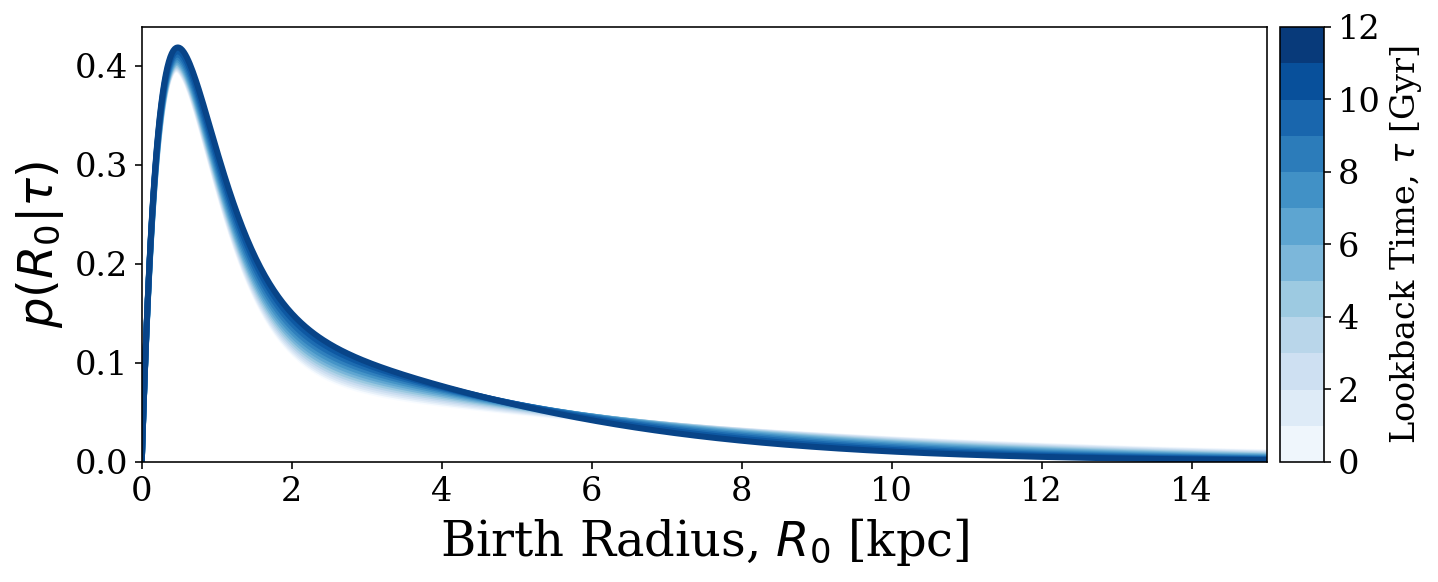

In [272]:
fig, ax = plt.subplots(1, figsize=(12, 4))

cmap = "Blues"

R_range = np.linspace(0, 20, 1000) * u.kpc
t_range = np.linspace(0, 12, 13)

# plot a separate distribution for lots of lookback times
for t in t_range:
#     ax.plot(R_range, P_R0(R_range, t * u.Gyr), lw=3, color=plt.get_cmap(cmap)((t / len(t_range))))
    ax.plot(R_range, total_radial(R_range, t * u.Gyr), lw=3, color=plt.get_cmap(cmap)((t / len(t_range))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(t_range)))
cbar = fig.colorbar(sm, boundaries=t_range, aspect=10, pad=0.01)
cbar.set_label(r"Lookback Time, $\tau$ [Gyr]", fontsize=0.7 * fs)
    
ax.set_xlabel(r"Birth Radius, $R_0$ [kpc]")
ax.set_xlim(0, 15)
ax.set_ylabel(r"$p(R_0 | \tau)$")
ax.set_ylim(bottom=0.0)

plt.show()

## Metallicity relation
Using F18, we can assume a tight metallicity-birth location-birth time relation and thus, for any given radius and time, we know the metallicity using the function below. We convert this from a ratio of elements to a mass fraction of metals using the function from Bertelli 1994.

In [190]:
def FeH(R, t):
    tm = 12 * u.Gyr
    Fm = -1
    grad = - 0.075 / u.kpc
    Rnow = 8.7 * u.kpc
    gamma = 0.3
    return Fm + grad * R - (Fm + grad * Rnow) * (1 - (t / tm))**(gamma)

def metallicity(R, t):
    # See Bertelli 1994 Equation 9
    zsun = 0.0142
    return np.power(10, 0.977 * FeH(R, t) + np.log10(zsun))

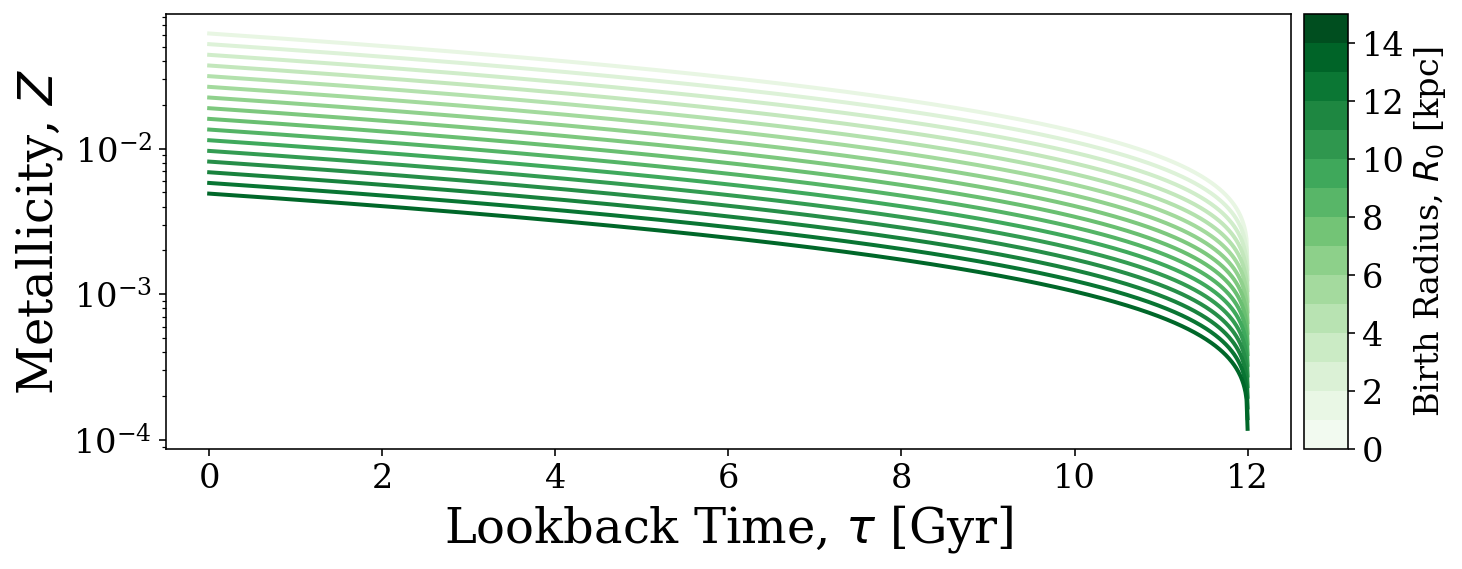

In [192]:
fig, ax = plt.subplots(1, figsize=(12, 4))

cmap = "Greens"

R_range = np.linspace(0, 15, 16)
t_range = np.linspace(0, 12, 1000) * u.Gyr
colors = plt.get_cmap(cmap, len(R_range) + 4)

for i in range(len(R_range)):
    ax.plot(t_range, metallicity(R_range[i] * u.kpc, t_range), lw=2, color=colors(i + 2))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(R_range)))
cbar = fig.colorbar(sm, boundaries=R_range, aspect=10, pad=0.01)
cbar.set_label(r"Birth Radius, $R_0$ [kpc]", fontsize=0.7 * fs)

ax.set_xlabel(r"Lookback Time, $\tau$ [Gyr]")
ax.set_xlim(-0.5, 12.5)
ax.set_ylabel(r"Metallicity, $Z$")
ax.set_yscale("log")

plt.show()

TODO: Metallicity of the sun is not the same as metallicity of the solar neighbourhood. Check Frankel, 0.0142 is from Asplund. Check Prizbilla also.

## Vertical spread
F18 assumes a flat thin disc so we supplement this with the distribution from McMillan (2011).

In [214]:
def P_z(z, zd=0.3 * u.kpc):
    return 1 / zd * np.exp(-z/zd)

def total_vertical(z):
    return stellar_mass_fractions["bulge"] * P_z(z, zd=1.5 * u.kpc) \
        + stellar_mass_fractions["thin"] * P_z(z, zd=0.3 * u.kpc) \
        + stellar_mass_fractions["thick"] * P_z(z, zd=0.95 * u.kpc)

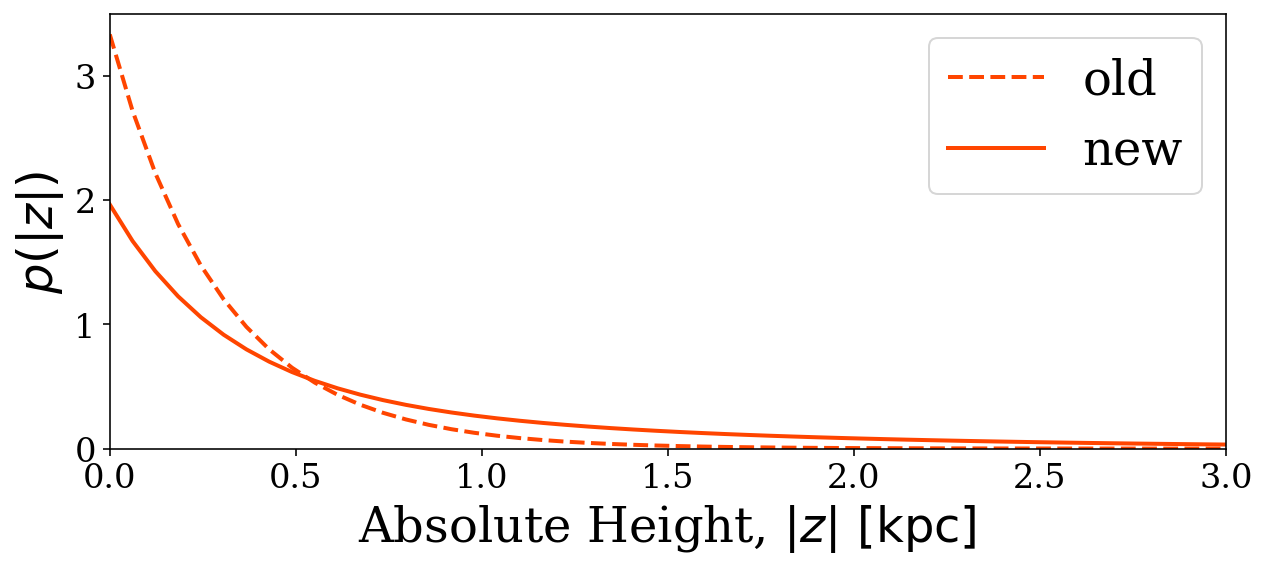

In [233]:
z_range = np.linspace(0, 3) * u.kpc

fig, ax = plt.subplots(1, figsize=(10, 4))

color = "orangered"

ax.plot(z_range, P_z(z_range, zd=0.3 * u.kpc), lw=2, color=color, linestyle="--", label="old")
# ax.fill_between(z_range, 0, P_z(z_range), color=color, alpha=0.2)

ax.plot(z_range, total_vertical(z_range), lw=2, color=color, label="new")
# ax.fill_between(z_range, 0, total_vertical(z_range), color=color, alpha=0.2)

ax.set_xlabel(r"Absolute Height, $|z|\ [\rm kpc]$")
ax.set_ylabel(r"$p(|z|)$")

ax.legend()

ax.set_xlim(0, max(z_range.value))
ax.set_ylim(bottom=0)

plt.show()

In [226]:
quad(lambda z: P_z(z * u.kpc).value, 0, 5)

(0.999999942222515, 3.626614314516919e-09)

In [227]:
quad(lambda z: total_vertical(z * u.kpc).value, 0, 5)

(0.9924587166449351, 1.1714741795506615e-09)

In [308]:
def random_lbt(size, tm=12*u.Gyr, tsfr=6.8*u.Gyr, min_time=0.0*u.Gyr, max_time=8*u.Gyr):
    U = np.random.rand(size)
    A = 1 / quad(lambda t: np.exp(-(tm - t * u.Gyr) / tsfr), min_time.to(u.Gyr).value, max_time.to(u.Gyr).value)[0]
    return tsfr * np.log( (U * np.exp(tm / tsfr)) / (A * tsfr.value) + np.exp(min_time / tsfr) )

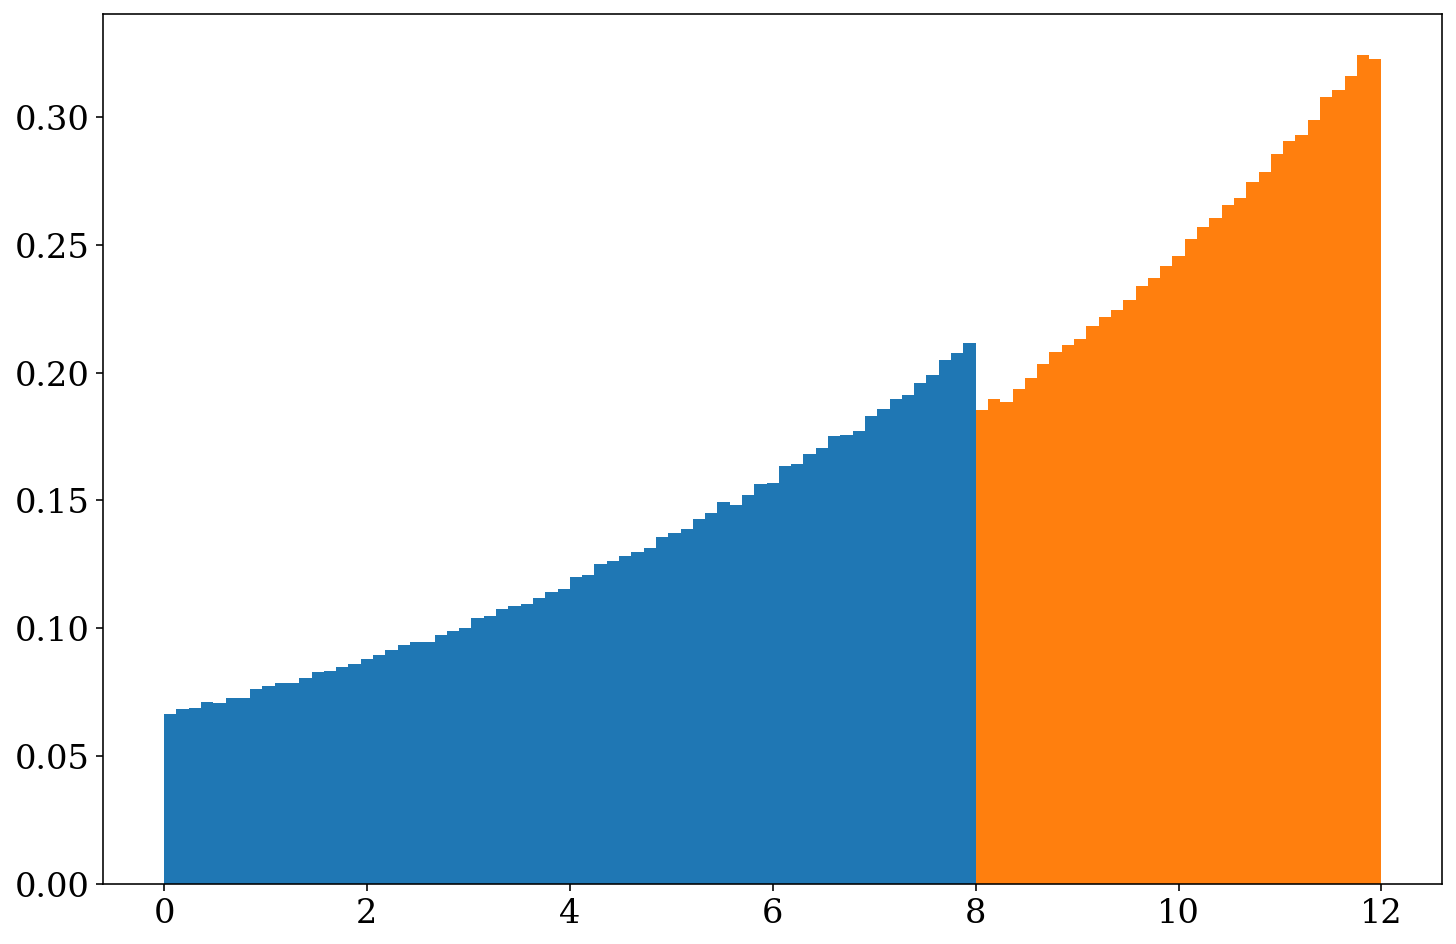

In [316]:
reload(galaxy)

plt.hist(galaxy.draw_lookback_times(1000000, component="thin_disc").value, bins=np.linspace(0, 12, 100), density=True)
plt.hist(galaxy.draw_lookback_times(1000000, component="thick_disc").value, bins=np.linspace(0, 12, 100), density=True)
plt.show()

In [364]:
reload(galaxy)
tau, R, Z = galaxy.simulate_mw(1000000)

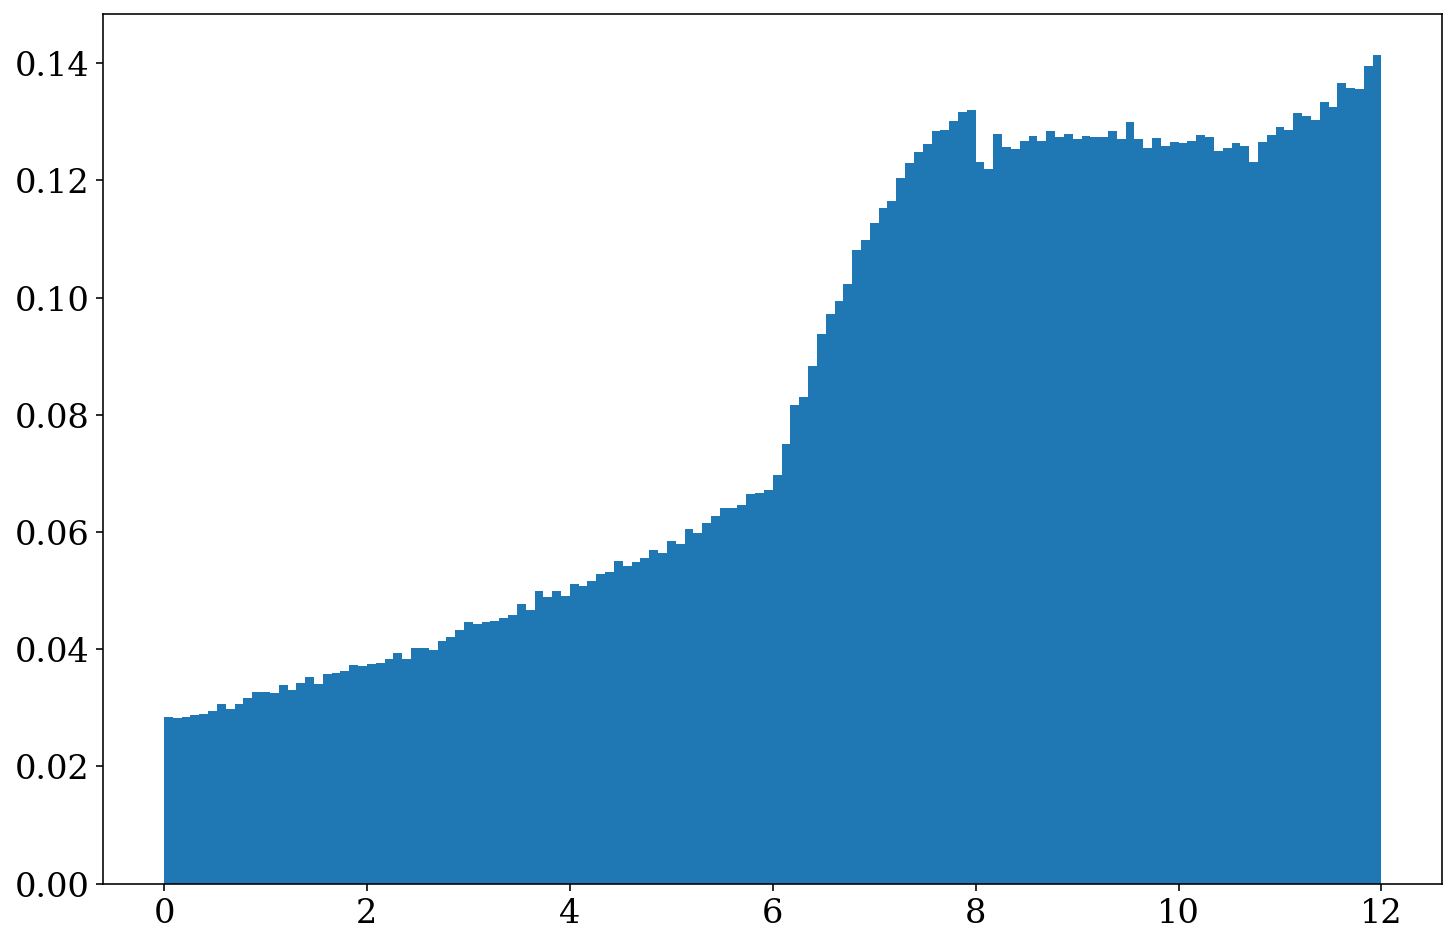

In [365]:
plt.hist(tau.value, bins="auto", density=True)
plt.show()

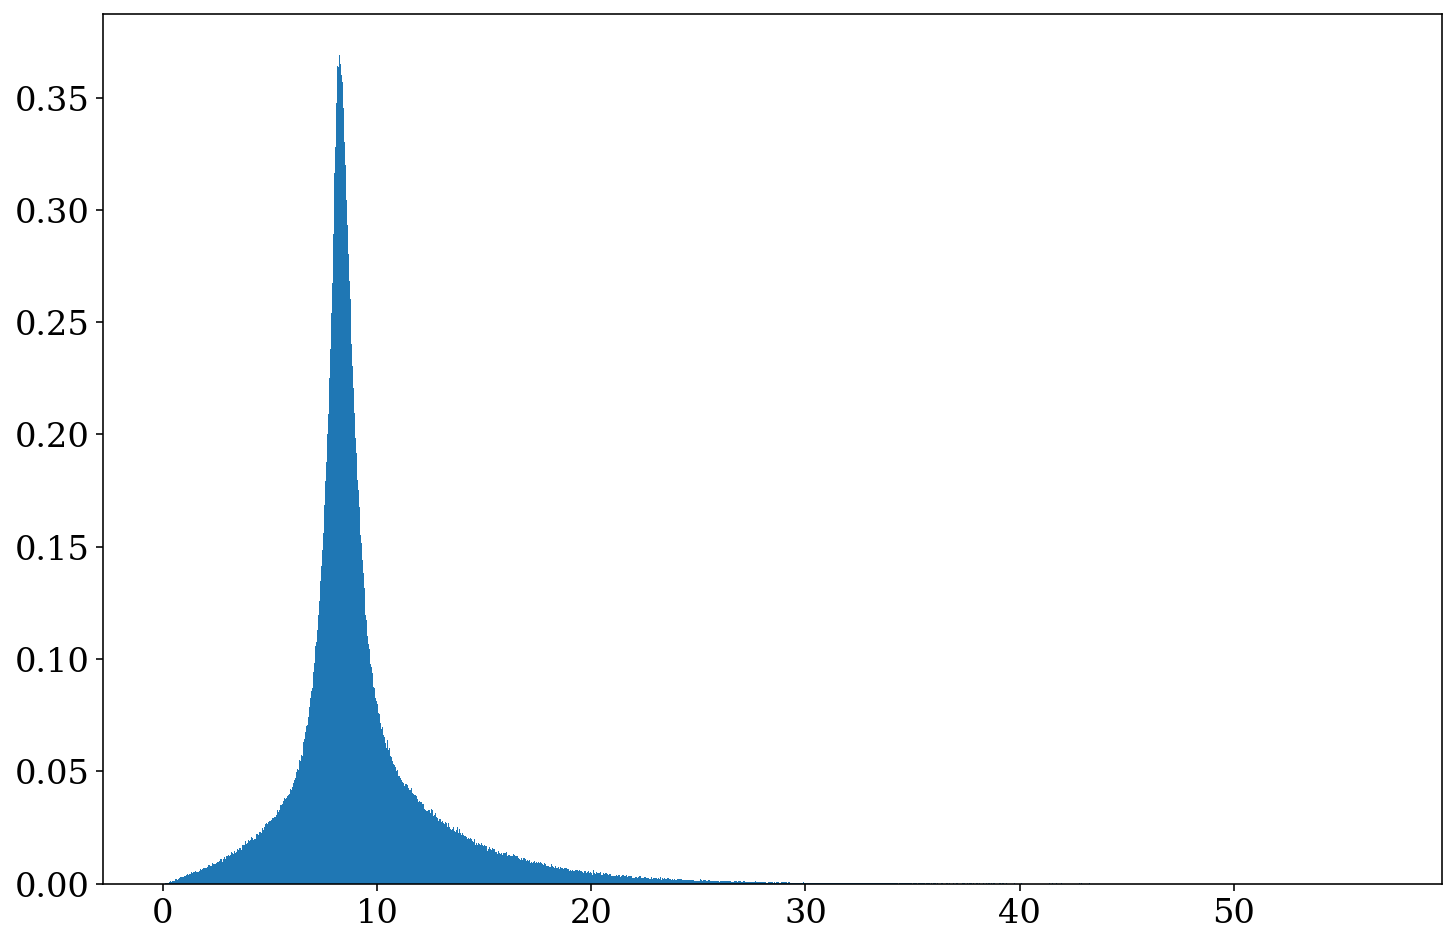

In [366]:
plt.hist(R.value, bins="auto", density=True)
plt.show()

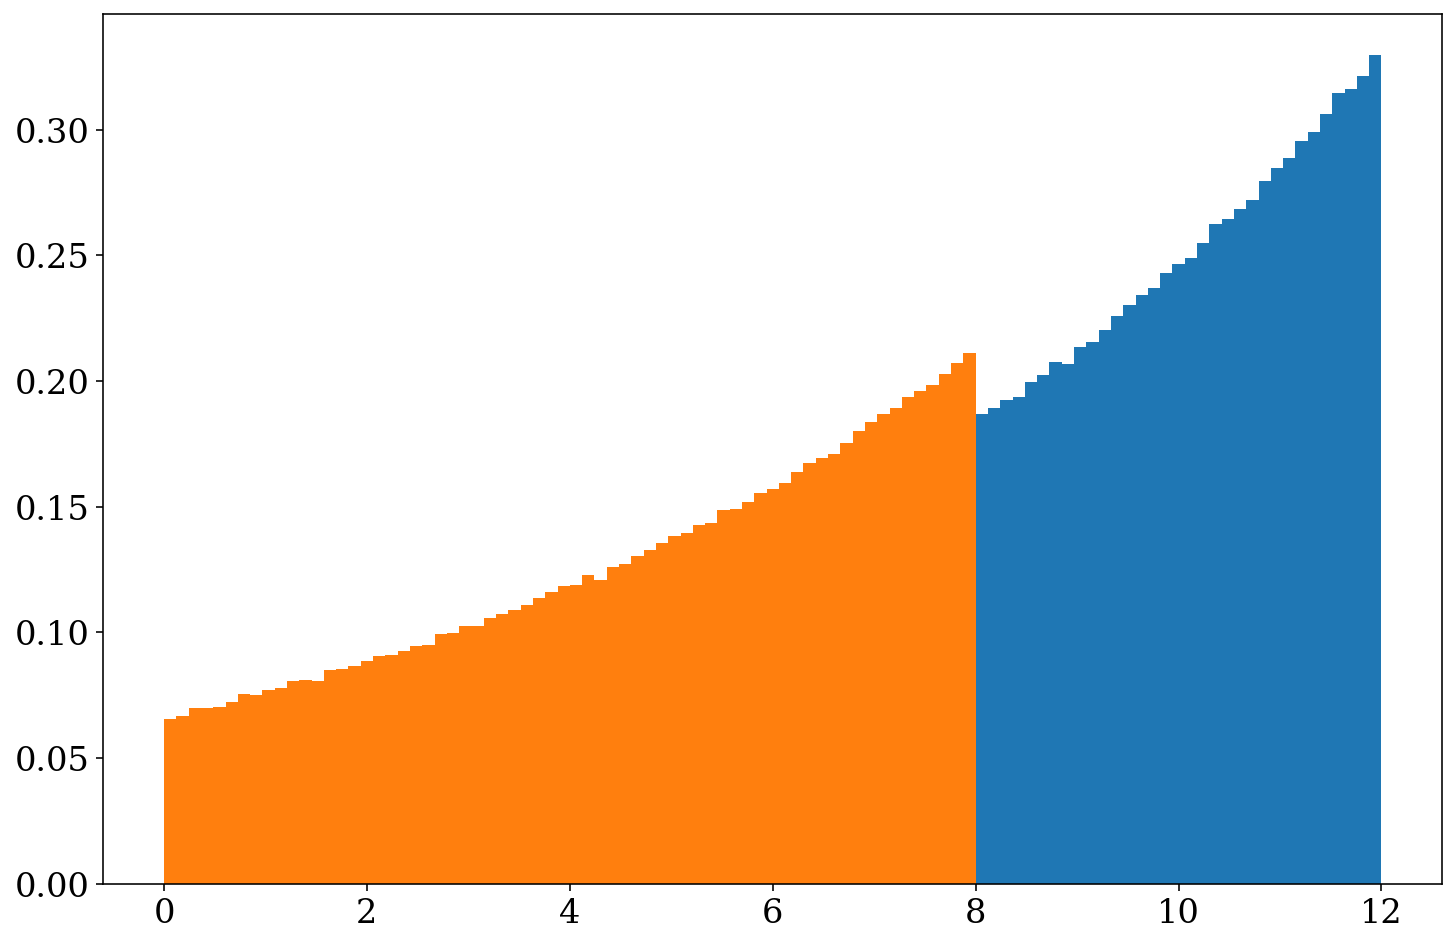

In [310]:
plt.hist(random_lbt(1000000, min_time=8 * u.Gyr, max_time=12*u.Gyr).value, bins=np.linspace(0, 12, 100), density=True)
plt.hist(random_lbt(1000000).value, bins=np.linspace(0, 12, 100), density=True)
plt.show()

# Put it all together
One function to rule them all

In [368]:
tm = 12 * u.Gyr
tau, D, Z, pos = galaxy.simulate_mw(200000, ret_pos=True)
R, z, theta = pos

min_Z_compas = 1e-4
max_Z_compas = 0.022

Z[Z < min_Z_compas] = 1e-4
Z[Z > max_Z_compas] = 10**(np.random.uniform(np.log10(0.01416), np.log10(max_Z_compas), len(Z[Z > max_Z_compas])))

x = R * np.cos(theta)
y = R * np.sin(theta)

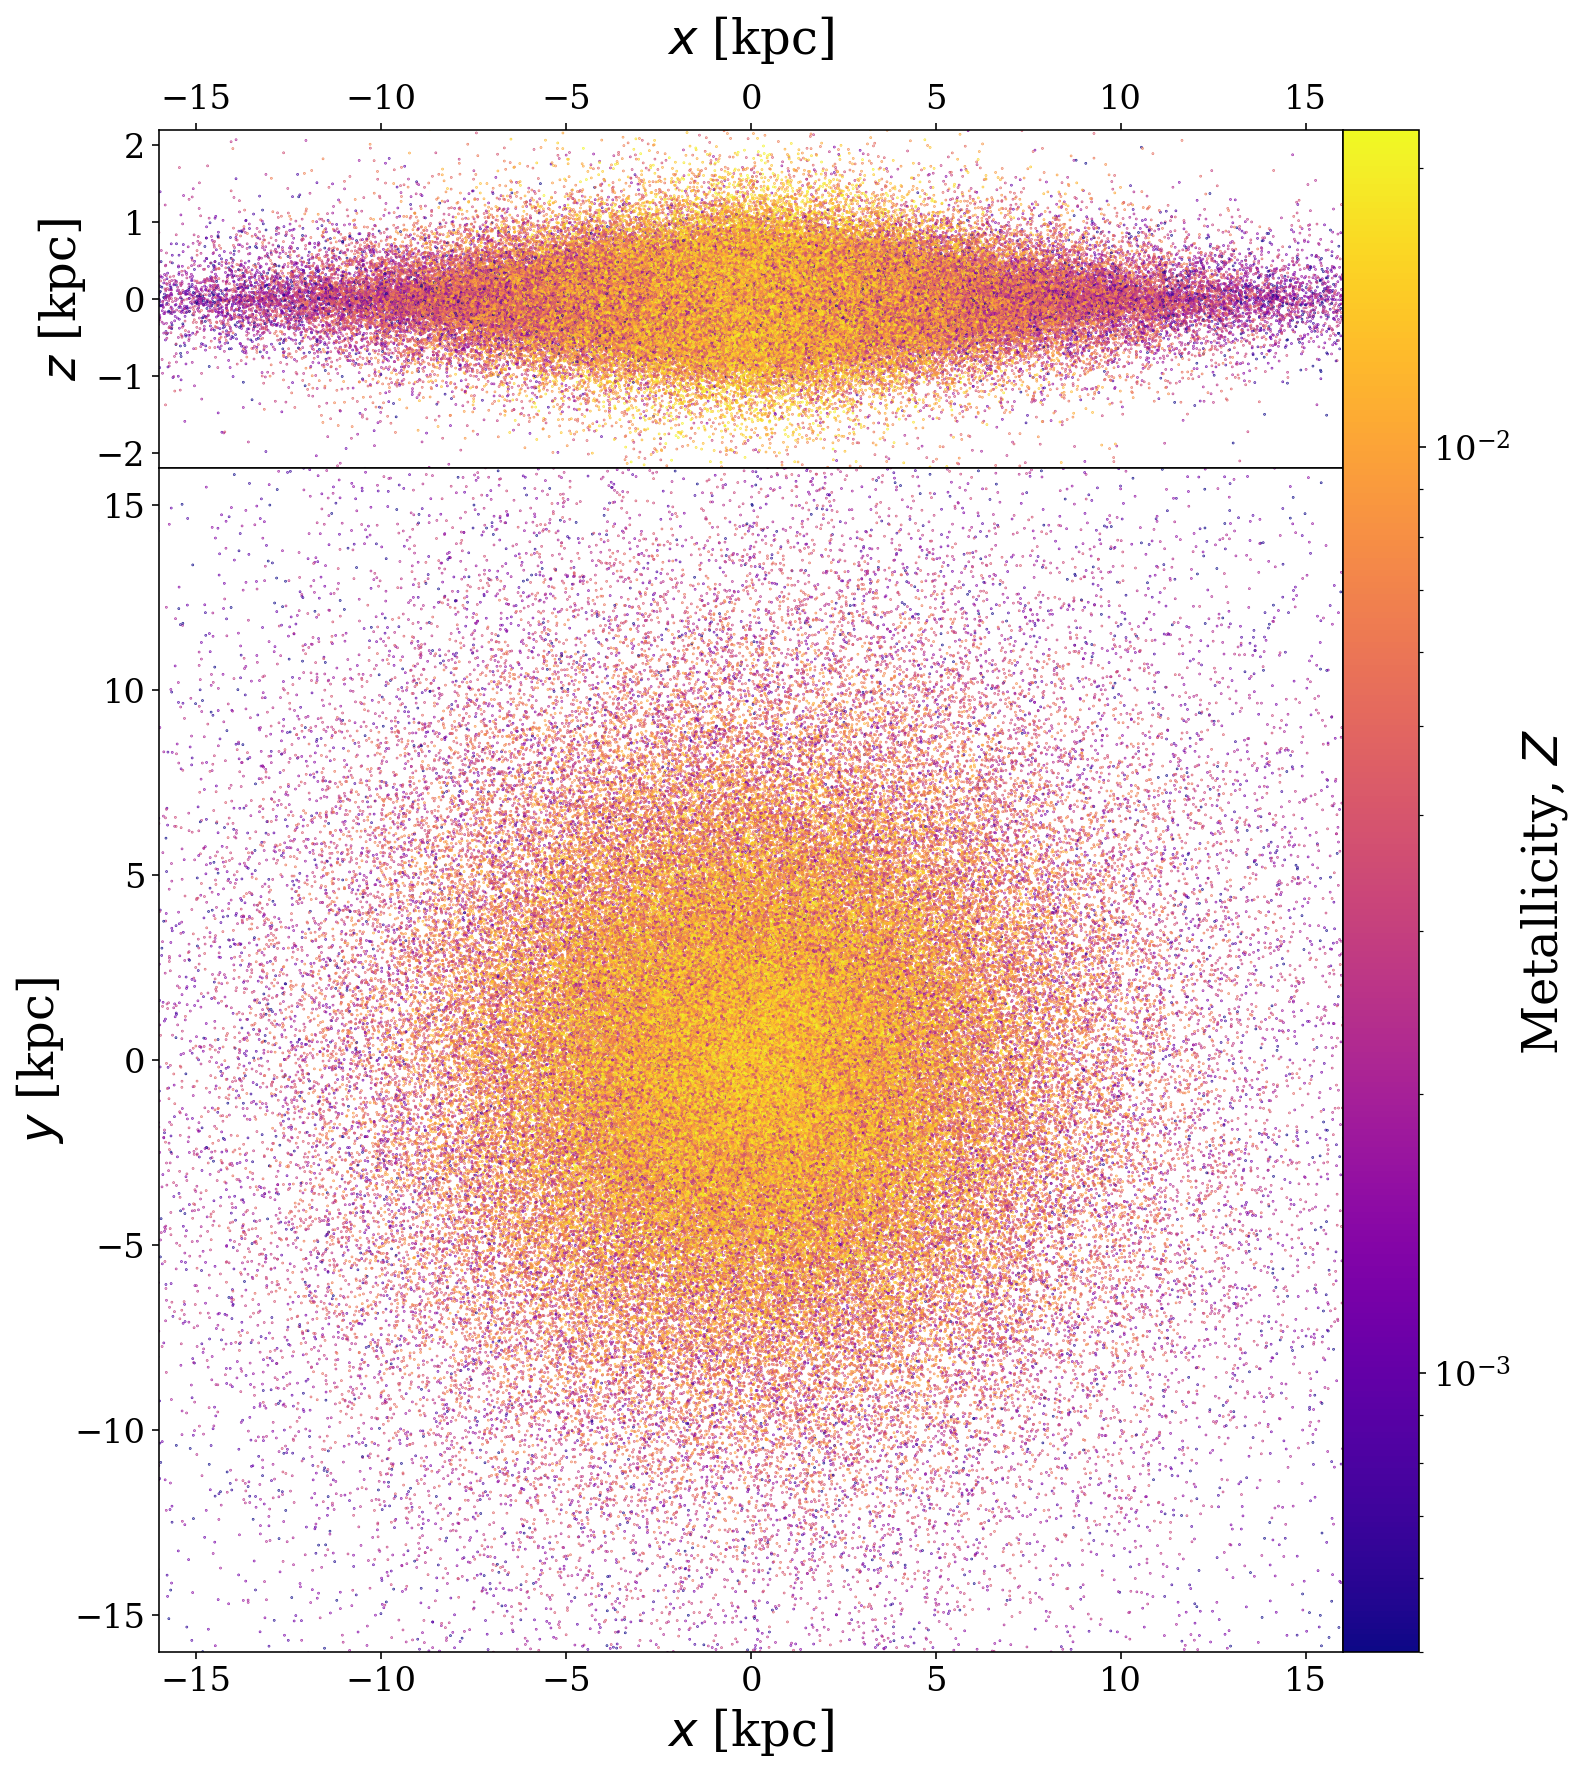

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(10 * 1.2475, 14), gridspec_kw={'height_ratios': [4, 14]})
axes[1].set_aspect("equal")
plt.subplots_adjust(hspace=0)

lim = 16

axes[0].scatter(x, z, c=Z.value, s=0.1, cmap="plasma", norm=LogNorm(vmin=5e-4))

axes[0].set_xlabel(r"$x$ [kpc]", labelpad=15)
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position("top")
axes[0].set_xlim(-lim, lim)

axes[0].set_ylabel(r"$z$ [kpc]")
axes[0].set_ylim(-2.2, 2.2)

scatt = axes[1].scatter(x.value, y.value, c=Z.value, s=0.1, cmap="plasma", norm=LogNorm(vmin=5e-4))
cbar = fig.colorbar(scatt, ax=axes, pad=0.0)
cbar.set_label(r"Metallicity, $Z$")

axes[1].set_xlabel(r"$x$ [kpc]")
axes[1].set_ylabel(r"$y$ [kpc]")

axes[1].set_xlim(-lim, lim)
axes[1].set_ylim(-lim, lim)

# plt.savefig("../plots/galaxy_metallicity.png", bbox_inches="tight")

plt.show()

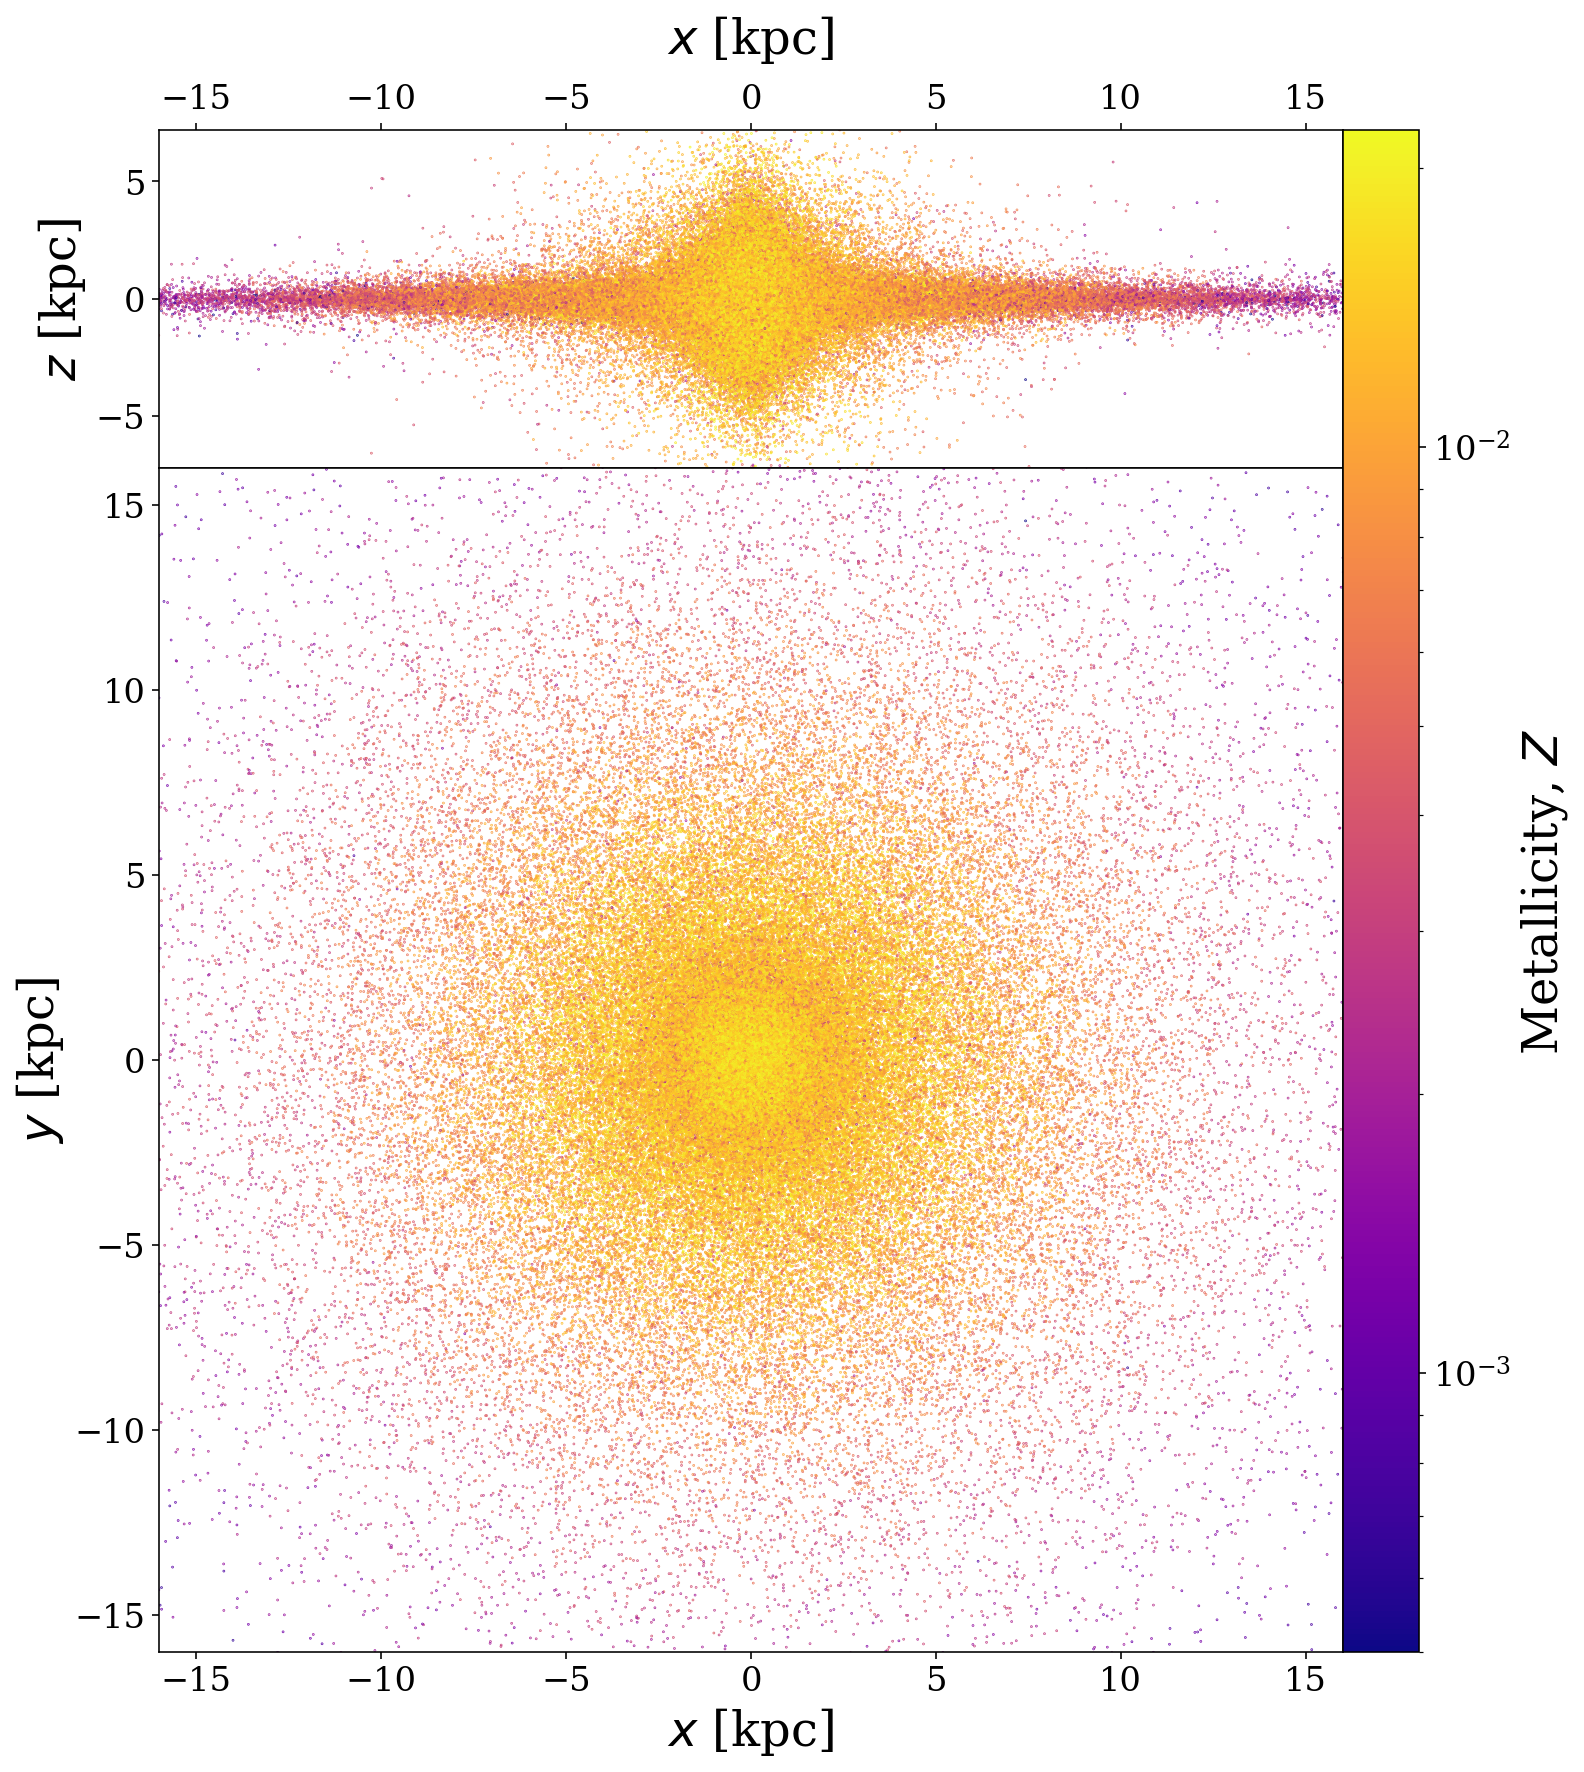

In [371]:
fig, axes = plt.subplots(2, 1, figsize=(10 * 1.2475, 14), gridspec_kw={'height_ratios': [4, 14]})
axes[1].set_aspect("equal")
plt.subplots_adjust(hspace=0)

lim = 16

axes[0].scatter(x, z, c=Z.value, s=0.1, cmap="plasma", norm=LogNorm(vmin=5e-4))

axes[0].set_xlabel(r"$x$ [kpc]", labelpad=15)
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position("top")
axes[0].set_xlim(-lim, lim)

axes[0].set_ylabel(r"$z$ [kpc]")
axes[0].set_ylim(-7.2, 7.2)

scatt = axes[1].scatter(x.value, y.value, c=Z.value, s=0.1, cmap="plasma", norm=LogNorm(vmin=5e-4))
cbar = fig.colorbar(scatt, ax=axes, pad=0.0)
cbar.set_label(r"Metallicity, $Z$")

axes[1].set_xlabel(r"$x$ [kpc]")
axes[1].set_ylabel(r"$y$ [kpc]")

axes[1].set_xlim(-lim, lim)
axes[1].set_ylim(-lim, lim)

# plt.savefig("../plots/galaxy_metallicity.png", bbox_inches="tight")

plt.show()

<hr>

In [379]:
tm = 12 * u.Gyr
tau, D, Z, pos = galaxy.simulate_mw(200000, components=["bulge"], masses=[1]*u.Msun, ret_pos=True)
R, z, theta = pos

min_Z_compas = 1e-4
max_Z_compas = 0.022

Z[Z < min_Z_compas] = 1e-4
Z[Z > max_Z_compas] = 10**(np.random.uniform(np.log10(0.01416), np.log10(max_Z_compas), len(Z[Z > max_Z_compas])))

x = R * np.cos(theta)
y = R * np.sin(theta)

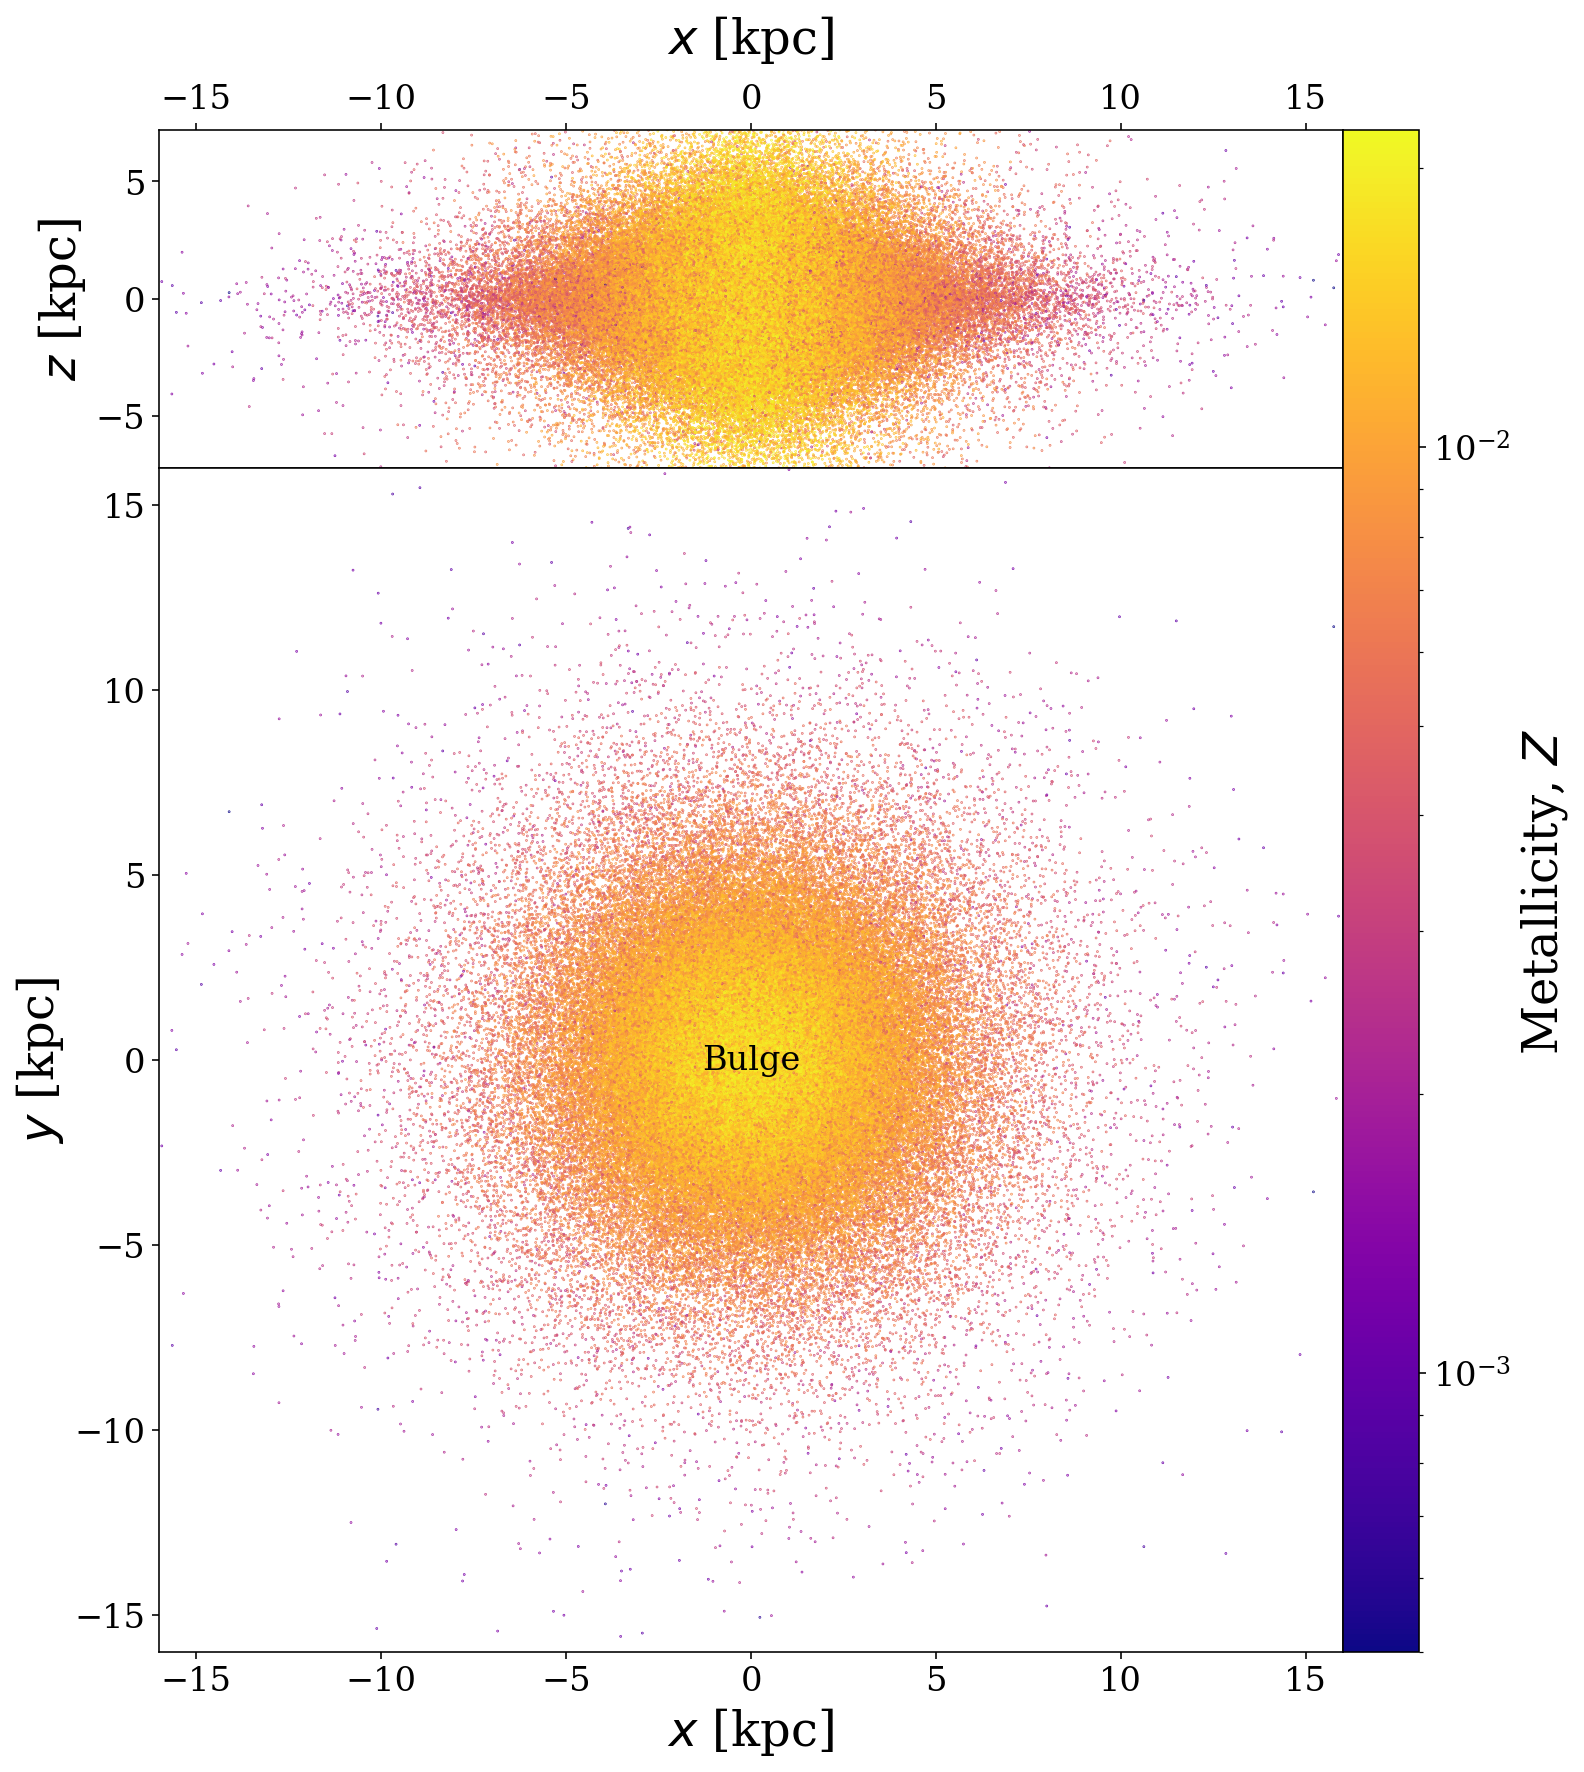

In [380]:
fig, axes = plt.subplots(2, 1, figsize=(10 * 1.2475, 14), gridspec_kw={'height_ratios': [4, 14]})
axes[1].set_aspect("equal")
plt.subplots_adjust(hspace=0)

lim = 16

axes[0].scatter(x, z, c=Z.value, s=0.1, cmap="plasma", norm=LogNorm(vmin=5e-4))

axes[0].set_xlabel(r"$x$ [kpc]", labelpad=15)
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position("top")
axes[0].set_xlim(-lim, lim)

axes[0].set_ylabel(r"$z$ [kpc]")
axes[0].set_ylim(-7.2, 7.2)

scatt = axes[1].scatter(x.value, y.value, c=Z.value, s=0.1, cmap="plasma", norm=LogNorm(vmin=5e-4))
cbar = fig.colorbar(scatt, ax=axes, pad=0.0)
cbar.set_label(r"Metallicity, $Z$")

axes[1].set_xlabel(r"$x$ [kpc]")
axes[1].set_ylabel(r"$y$ [kpc]")

axes[1].set_xlim(-lim, lim)
axes[1].set_ylim(-lim, lim)

axes[1].annotate("Bulge", xy=(0, 0), ha="center", va="center", fontsize=0.7*fs)

# plt.savefig("../plots/galaxy_metallicity.png", bbox_inches="tight")

plt.show()